# Time Series Clustering Demo

## Set-up

### Load modules

In [1]:
import os # module for interacting with files and folders
from audio_processing import *
from audio_display import *
from array_manipulation import *
from load_audio import *
from feature_normalize import *
from pca_paths import *
from frame_clustering import *
from segments import *
from time_series import *

### Load Audio Files

In [2]:
paths = [r'sound/American-English/Narrative',
        r'sound/American-English/Consonants',
        r'sound/American-English/Vowels',
        r'sound/Non-speech']

out_path = 'sound/out/'

fns,audio_data = load_audio(paths_list=paths, pad=0,nonspeech_dur=0)

narrative_fns,consonants_fns,vowels_fns,nonspeech_fns = fns
narrative_data,consonants_data,vowels_data,nonspeech_data = audio_data

### Normalization from Narrative Data

In [3]:
narr = get_narr(narrative_fns,pad=0)
narr_scaler = get_scaler(narrative_fns)

narr_frames = np.transpose(norm_array_hor(narr,narr_scaler))
print(narr_frames.shape)

narr_pca = PCA(n_components=3).fit(narr_frames)
narr_pcs = narr_pca.transform(narr_frames)
print(f'Explained variance ratio: \n{narr_pca.explained_variance_ratio_}')

(9549, 12)
Explained variance ratio: 
[0.27587223 0.17633553 0.15477869]


In [4]:
clip_dict = {}
path_test_fns = vowels_fns+consonants_fns+nonspeech_fns
for clip_fn in path_test_fns:
  name = clip_fn.split("/")[-1].split(".")[0].title()
  clip_data = process_audio(clip_fn,n_mfcc_list=[12],pad = 0)
  fourier = clip_data["fourier"]
  sr = clip_data["sr"]
  normed_mfcc = norm_array_hor(clip_data["mfcc"]["12"],narr_scaler)
  clip_frames = np.transpose(normed_mfcc)
  clip_pca = narr_pca.transform(clip_frames)
  clip_dict[name] = {"frames":clip_frames,"pca":clip_pca}

print(clip_dict.keys())
print(clip_dict["Bird"].keys())
print(clip_dict["Bird"]['frames'].shape)
print(clip_dict["Bird"]['pca'].shape)

dict_keys(['Bird', 'Bed', 'Bid', 'Above', 'Bayed', 'Good', 'Buy', 'Bud', 'Bead', 'Bough', 'Bad', 'Boy', 'Booed', 'Bode', 'Pod', 'Sigh', 'Shy', 'Fie', 'Rye', 'Die', 'Why', 'Hang', 'Guy', 'Thigh', 'You', 'Thy', 'Gin', 'Vie', 'My', 'Azure', 'Tie', 'High', 'Pie', 'Kite', 'Chin', 'Lie', 'Nigh', 'Zoo', 'Train', 'Water'])
dict_keys(['frames', 'pca'])
(202, 12)
(202, 3)


### Generate Segmentation

Sample rate = 22050
Frame Width = 2.902 ms
Length of segmentation: 197 intervals


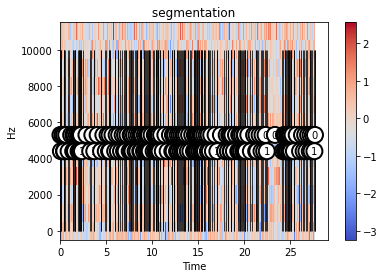

In [5]:
word = "Above"

common_params = {"linkage": "complete",
    "distance_threshold": 20,
    "affinity": "manhattan",
    "connectivity": None,
    "compute_full_tree": True,
    "n_clusters": None,
}






data = [item for sublist in audio_data for item in sublist]
word_data = next(item for item in data if item["fn"].split("/")[-1].split(".")[0].title() == word)


agg_clusters_clip = AgglomerativeClustering(**common_params)
y_pred = agg_clusters_clip.fit_predict(narr_frames)

clustering = list(y_pred)

res = 3
sr = sr
hop = 2**(9-res)
w = hop/sr

sig_figs = 3


print(f"Sample rate = {sr}")
print(f"Frame Width = {round(1000*w,sig_figs)} ms")
segmentation = get_intervals(clustering,frame_w=w)
print(f"Length of segmentation: {len(segmentation)} intervals")

#plot_timeseries_on_spectrogram(word_data["fourier"],y_pred,sr,scale_ts=1,title=f"{word} segmentation ",line_color='red')
#plot_timeseries_on_mfcc(np.transpose(X),y_pred,sr,scale_ts=1,title=f" segmentation ",line_color='black')
plot_segments_on_mfcc(np.transpose(narr_frames),segmentation,sr,title=f" segmentation ",line_color='black')



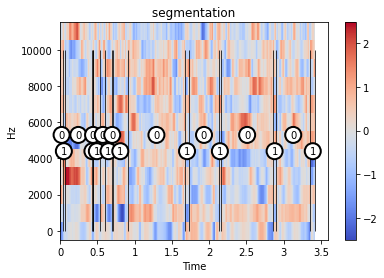

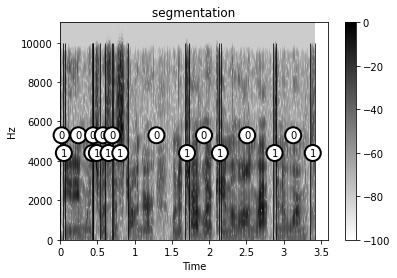

In [6]:
start_seg = 12
end_seg = 29

start_frame = segmentation[start_seg]["fmin"]
end_frame = segmentation[end_seg]["fmax"]

trimmed_X = np.split(narr_frames,[start_frame,end_frame],axis = 0)[1]

trimmed_fourier = np.split(narrative_data[0]["fourier"],[start_frame,end_frame],axis = 1)[1]

trimmed_segmentation = copy.deepcopy(segmentation[start_seg:end_seg+1])
for interval in trimmed_segmentation:
    interval["fmin"] -= start_frame
    interval["fmax"] -= start_frame
    interval["tmin"] -= start_frame*w
    interval["tmax"] -= start_frame*w

plot_segments_on_mfcc(np.transpose(trimmed_X),trimmed_segmentation,sr,title=f" segmentation ",line_color='black')
plot_segments_on_spectrogram(trimmed_fourier,trimmed_segmentation,sr,title=f" segmentation ",line_color='black')

out_path = 'sound/out/'
export_audio_from_timeseries(out_path+"clip_from_fourier.wav",timeseries_from_fourier(trimmed_fourier,sr),sr)
Audio(out_path+"clip_from_fourier.wav")

### Split MFCC

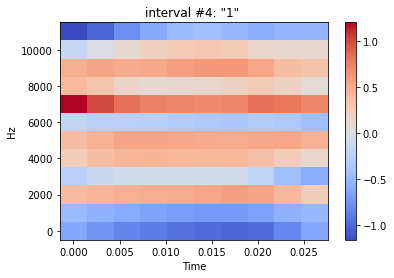

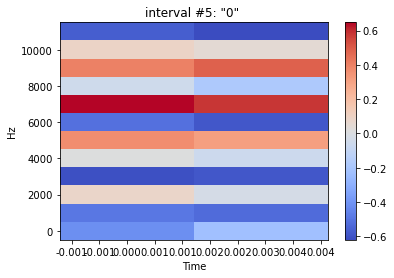

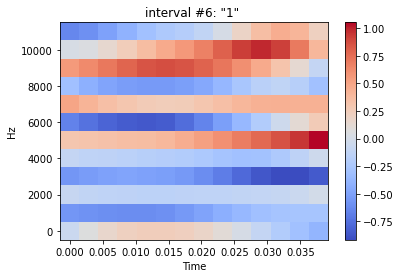

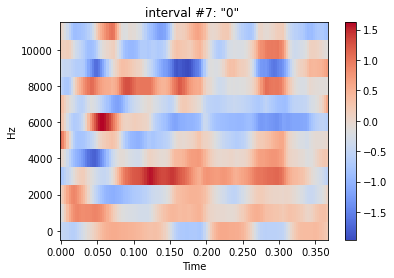

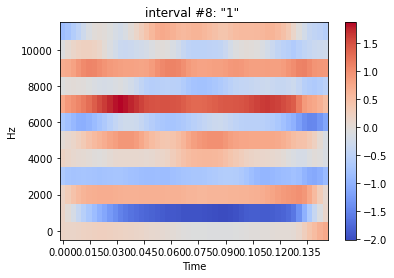

In [7]:
split_mfcc = split_frames(segmentation,narr_frames)

for i,interval in enumerate(split_mfcc):
    if 2<i<8:
        plot_mfcc(np.transpose(interval["frames"]),title=f'interval #{i+1}: \"{interval["text"]}\" ',sr= clip_data["sr"])

#split_fourier = split_frames(segmentation,np.transpose(word_data["fourier"]))

## Time Series Clustering

### Preprocessing

In [8]:
time_series_list = [interval['frames'] for interval in split_mfcc]
print(len(time_series_list))
time_series_list = [frames for frames in time_series_list if frames.shape[0] >= 2]
print(len(time_series_list))
X = to_time_series_dataset(time_series_list)
time_scaler = TimeSeriesScalerMeanVariance()
X = time_scaler.fit_transform(X)
X = TimeSeriesResampler(sz=40).fit_transform(X)
sz = X.shape[1]

197
194


### Model fitting

In [9]:
km = TimeSeriesKMeans(n_clusters=12, metric="dtw")
labels = km.fit_predict(X)
silhouette_score(X, labels, metric="dtw")

0.05524936425801217

(915, 12)


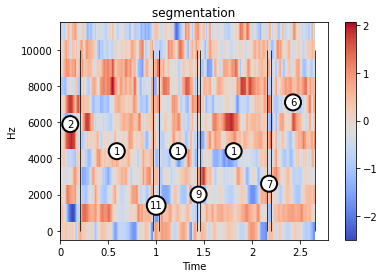

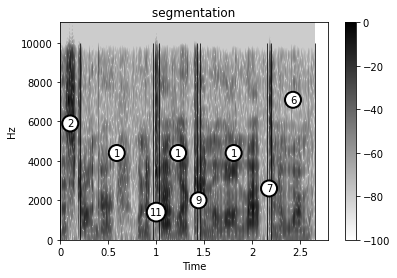

In [10]:
new_segmentation = relabel_segments(labels,segmentation)

#plot_segments_on_mfcc(np.transpose(X),new_segmentation,sr,title=f" segmentation ",line_color='black')


start_seg = 18
end_seg = 25

start_frame = new_segmentation[start_seg]["fmin"]
end_frame = new_segmentation[end_seg]["fmax"]

trimmed_X = np.split(narr_frames,[start_frame,end_frame],axis = 0)[1]

trimmed_fourier = np.split(narrative_data[0]["fourier"],[start_frame,end_frame],axis = 1)[1]

print(trimmed_X.shape)

trimmed_new_segmentation = copy.deepcopy(new_segmentation[start_seg:end_seg+1])
for interval in trimmed_new_segmentation:
    interval["fmin"] -= start_frame
    interval["fmax"] -= start_frame
    interval["tmin"] -= start_frame*w
    interval["tmax"] -= start_frame*w

plot_segments_on_mfcc(np.transpose(trimmed_X),trimmed_new_segmentation,sr,title=f" segmentation ",line_color='black')
plot_segments_on_spectrogram(trimmed_fourier,trimmed_new_segmentation,sr,title=f" segmentation ",line_color='black')

out_path = 'sound/out/'
export_audio_from_timeseries(out_path+"clip_from_fourier.wav",timeseries_from_fourier(trimmed_fourier,sr),sr)
Audio(out_path+"clip_from_fourier.wav")

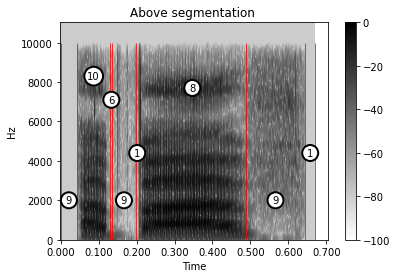

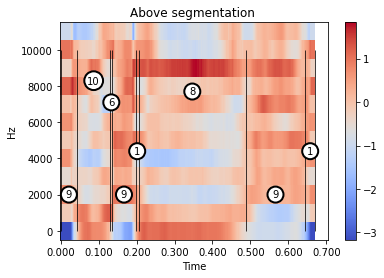

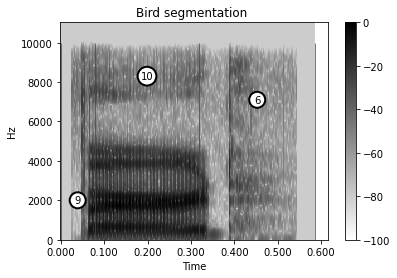

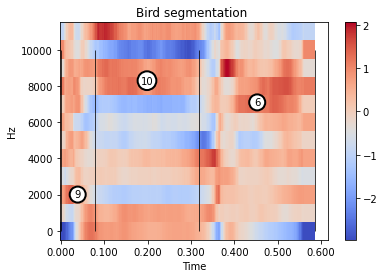

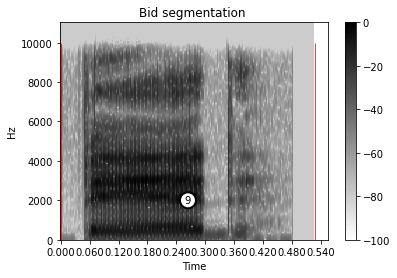

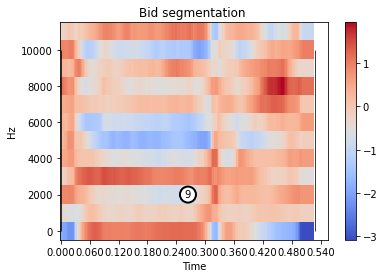

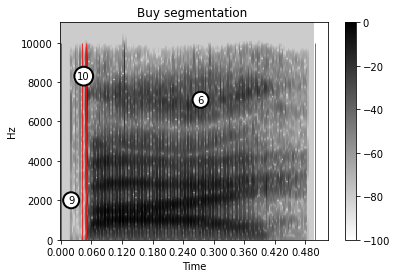

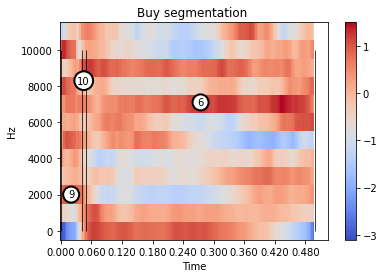

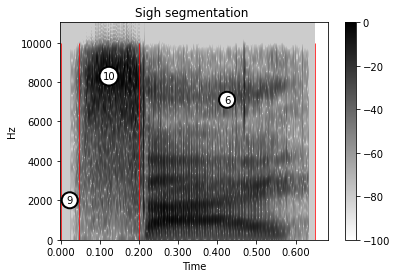

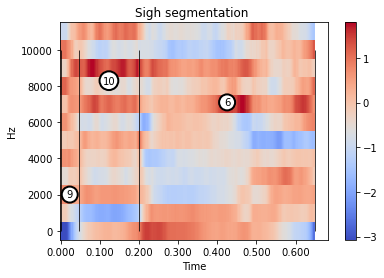

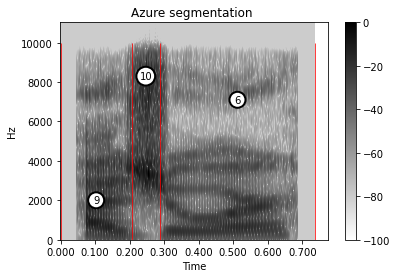

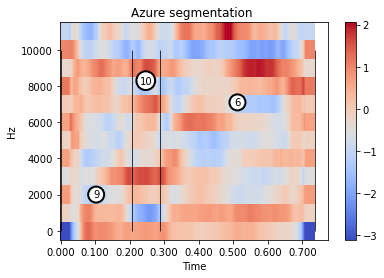

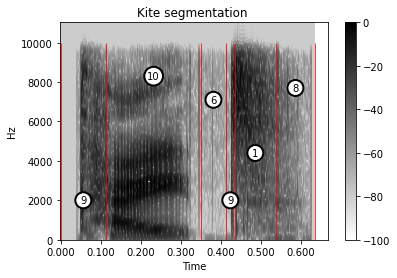

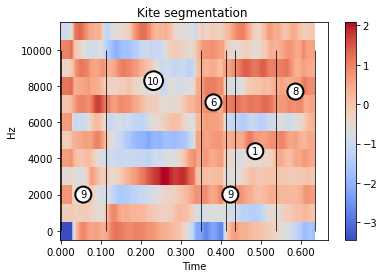

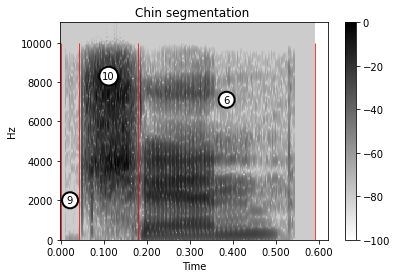

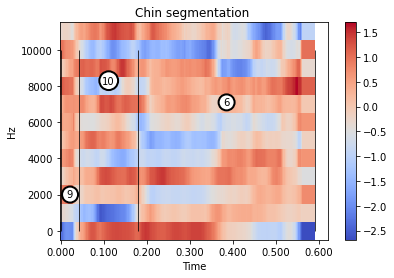

In [11]:
common_params = {
    "connectivity": None,
    "compute_full_tree": True,
    "n_clusters": None
}

res = 3
sr = sr
hop = 2**(9-res)
w = hop/sr


data = [item for sublist in audio_data for item in sublist]

linkage = "complete"
distance_threshold = 20

for i,word in enumerate(['Above', 'Bird', 'Bid', 'Buy', 'Sigh', 'Azure', 'Kite', 'Chin']):

    clip = clip_dict[word]


    clip_len = clip["frames"].shape[0]

    X_combined = np.concatenate([clip["frames"],narr_frames],axis=0)

    
    word_data = next(item for item in data if item["fn"].split("/")[-1].split(".")[0].title() == word)

    agg_clusters_clip = AgglomerativeClustering(linkage = linkage, distance_threshold = distance_threshold, affinity="manhattan", **common_params)
    y_pred_combined = agg_clusters_clip.fit_predict(X_combined)

    y_pred = np.split(y_pred_combined,[clip_len])[0]

    clip_segmentation = get_intervals(list(y_pred),frame_w=w)

    clip_split_mfcc = split_frames(clip_segmentation,clip["frames"])

    clip_time_series_list = [interval['frames'] for interval in clip_split_mfcc]

    clip_time_series_list = [frames for frames in time_series_list if frames.shape[0] >= 2]

    X_test = to_time_series_dataset(clip_time_series_list)

    #X_test = time_scaler.transform(X_test)

    X_test = TimeSeriesResampler(sz=sz).fit_transform(X_test)

    labels_test = km.predict(X_test)

    new_clip_segmentation = new_segmentation = relabel_segments(labels_test,clip_segmentation)

    plot_segments_on_spectrogram(word_data["fourier"],new_clip_segmentation,sr,title=f"{word} segmentation ",line_color='red')
    plot_segments_on_mfcc(np.transpose(clip_dict[word]['frames']),new_clip_segmentation,sr,title=f"{word} segmentation ",line_color='black')

    
